# Skenario 2: Gradual Unfreezing

Notebook ini menjalankan skenario kedua dari penelitian transfer learning: **Gradual Unfreezing**.

**Tujuan:**
- Mencegah *catastrophic forgetting* dengan melatih model secara bertahap.
- Membandingkan apakah teknik ini memberikan performa yang lebih baik atau lebih stabil dibandingkan fine-tuning standar.

**Metodologi:**
Proses training akan dibagi menjadi tiga tahap untuk setiap model:
1.  **Tahap 1:** Hanya melatih *classifier head* yang baru ditambahkan. Seluruh *base model* (BERT/RoBERTa) dibekukan. Menggunakan *learning rate* (LR) yang relatif besar.
2.  **Tahap 2:** Membuka (unfreeze) beberapa layer teratas dari *base model*. Melatihnya bersama *classifier head* dengan LR yang lebih kecil.
3.  **Tahap 3:** Membuka semua layer. Melatih seluruh model dengan LR yang sangat kecil untuk penyesuaian akhir.

In [ ]:
%%capture
%pip install transformers[torch] datasets scikit-learn pandas matplotlib seaborn tqdm --upgrade

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, get_linear_schedule_with_warmup, logging
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import gc

# Konfigurasi dasar
logging.set_verbosity_error()
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_theme(style="whitegrid", palette="muted")
plt.style.use('ggplot')

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan perangkat: {DEVICE}")

MODEL_CONFIGS = {
    "IndoBERTbase": "indobenchmark/indobert-base-p1",
    "IndoBERTweet": "indolem/indobertweet-base-uncased",
    "RoBERTa": "databoks-irfan/twitter-comment-roberta-base-indonesian-smsa"
}

DATA_PATH = '../data/pemilu_data_preprocesed.csv' 

STAGE_EPOCHS = (1, 2, 2)  # (Tahap 1, Tahap 2, Tahap 3)

STAGE_LRS = (1e-3, 1e-5, 2e-6) # (LR Tahap 1, LR Tahap 2, LR Tahap 3)

LAYERS_TO_UNFREEZE = 4

# Hyperparameters lainnya
RANDOM_STATE = 42
MAX_LEN = 128
BATCH_SIZE = 16
WEIGHT_DECAY = 0.01
DROPOUT_RATE = 0.2

Menggunakan perangkat: cuda


In [4]:
class SentimentDataset(Dataset):
    """Dataset class untuk sentimen."""
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx]); label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            return_token_type_ids=False, padding='max_length',
            truncation=True, return_attention_mask=True, return_tensors='pt',)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [5]:
def compute_metrics(labels, preds):
    """Menghitung metrik evaluasi."""
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average='weighted', zero_division=0),
        "recall": recall_score(labels, preds, average='weighted', zero_division=0),
        "f1": f1_score(labels, preds, average='weighted', zero_division=0)
    }

In [6]:
def load_and_split_data(path, text_column='text', label_column='sentiment', test_size=0.2, random_state=42):
        df = pd.read_csv(path)
        print(f"Kolom yang terdeteksi: {df.columns.tolist()}")
        
        label_map = {"neutral": 0, "positive": 1, "negative": 2}
        df['label_id'] = df[label_column].map(label_map)
        
        initial_rows = len(df)
        df.dropna(subset=[text_column, 'label_id'], inplace=True)
        cleaned_rows = len(df)
        if initial_rows > cleaned_rows:
            print(f"Membersihkan data: {initial_rows - cleaned_rows} baris dihapus karena nilai kosong.")
            
        df['label_id'] = df['label_id'].astype(int)

        # Siapkan data untuk splitting
        texts = df[text_column].values
        labels = df['label_id'].values

        splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, val_idx = next(splitter.split(texts, labels))
        
        train_texts, val_texts = texts[train_idx], texts[val_idx]
        train_labels, val_labels = labels[train_idx], labels[val_idx]
        
        print(f"Data berhasil dimuat dan dibagi.")
        print(f"  - Jumlah data latih: {len(train_texts)}")
        print(f"  - Jumlah data validasi: {len(val_texts)}")
        
        return {
            "train_texts": train_texts, 
            "train_labels": train_labels,
            "val_texts": val_texts, 
            "val_labels": val_labels,
            "num_labels": len(label_map)
        }

In [7]:
data_dict = load_and_split_data(
    path=DATA_PATH,
    text_column='text',        
    label_column='sentiment'   
)

Kolom yang terdeteksi: ['text', 'sentiment']
Data berhasil dimuat dan dibagi.
  - Jumlah data latih: 17764
  - Jumlah data validasi: 4441


In [8]:
def average_histories(histories):
    """Merata-ratakan riwayat dari beberapa fold."""
    if not histories:
        return {}
    
    avg_history = {}
    # Ambil semua key dari histori pertama (asumsi semua sama)
    metric_keys = histories[0].keys()
    # Dapatkan jumlah epoch maksimum dari semua fold
    max_epochs = max(len(h['train_loss']) for h in histories)

    for key in metric_keys:
        # Kumpulkan nilai metrik dari semua fold, pad dengan NaN jika epoch lebih sedikit
        padded_values = [h[key] + [np.nan] * (max_epochs - len(h[key])) for h in histories]
        avg_history[key] = np.nanmean(padded_values, axis=0)
        
    return avg_history

In [9]:
def train_epoch(model, data_loader, optimizer, device, scaler, scheduler):
    """Satu epoch training."""
    model.train()
    total_loss, all_preds, all_labels = 0, [], []
    
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        with autocast(device_type=device.type, dtype=torch.float16):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        all_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    metrics = compute_metrics(all_labels, all_preds)
    return avg_loss, metrics

In [10]:
def evaluate_epoch(model, data_loader, device):
    """Satu epoch evaluasi."""
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    
    progress_bar = tqdm(data_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            with autocast(device_type=device.type, dtype=torch.float16):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                
            total_loss += loss.item()
            all_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    metrics = compute_metrics(all_labels, all_preds)
    return avg_loss, metrics

In [11]:
def run_gradual_unfreezing_scenario(model_name_hf, data_dict, device):
    """Menjalankan siklus training Gradual Unfreezing untuk satu model."""
    
    print(f"\nMemulai Skenario Gradual Unfreezing untuk: {model_name_hf}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name_hf)
    train_dataset = SentimentDataset(data_dict['train_texts'], data_dict['train_labels'], tokenizer, MAX_LEN)
    val_dataset = SentimentDataset(data_dict['val_texts'], data_dict['val_labels'], tokenizer, MAX_LEN)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2)

    config = AutoConfig.from_pretrained(model_name_hf, num_labels=data_dict['num_labels'], classifier_dropout=DROPOUT_RATE)
    model = AutoModelForSequenceClassification.from_pretrained(model_name_hf, config=config).to(device)

    history = {
        'train_loss': [], 'train_accuracy': [], 'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_loss': [], 'val_accuracy': [], 'val_precision': [], 'val_recall': [], 'val_f1': []
    }
    def update_history(train_loss, train_metrics, val_loss, val_metrics):
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        for metric_name in ['accuracy', 'precision', 'recall', 'f1']:
            history[f'train_{metric_name}'].append(train_metrics[metric_name])
            history[f'val_{metric_name}'].append(val_metrics[metric_name])

    print("\n--- Tahap 1: Melatih Classifier Head ---")
    
    # Bekukan semua layer di base model
    for param in model.base_model.parameters():
        param.requires_grad = False

    # Buat optimizer hanya untuk parameter yang bisa dilatih (classifier)
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=STAGE_LRS[0])
    scaler = GradScaler()
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_loader) * STAGE_EPOCHS[0])

    print(f"Parameter terlatih: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    for epoch in range(STAGE_EPOCHS[0]):
        train_loss, train_metrics = train_epoch(model, train_loader, optimizer, device, scaler, scheduler)
        val_loss, val_metrics = evaluate_epoch(model, val_loader, device)
        update_history(train_loss, train_metrics, val_loss, val_metrics) 
    print(f"Hasil Tahap 1 -> Val F1: {val_metrics['f1']:.4f}")

    print(f"\n--- Tahap 2: Membuka {LAYERS_TO_UNFREEZE} Layer Teratas ---")
    
    encoder_layers = model.base_model.encoder.layer
    for layer in encoder_layers[-LAYERS_TO_UNFREEZE:]:
        for param in layer.parameters():
            param.requires_grad = True

    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=STAGE_LRS[1])
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_loader) * STAGE_EPOCHS[1])

    print(f"Parameter terlatih: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    for epoch in range(STAGE_EPOCHS[1]):
        train_loss, train_metrics = train_epoch(model, train_loader, optimizer, device, scaler, scheduler)
        val_loss, val_metrics = evaluate_epoch(model, val_loader, device)
        update_history(train_loss, train_metrics, val_loss, val_metrics)
    print(f"Hasil Tahap 2 -> Val F1: {val_metrics['f1']:.4f}")

    print("\n--- Tahap 3: Membuka Semua Layer ---")
    
    for param in model.base_model.parameters():
        param.requires_grad = True

    optimizer = AdamW(model.parameters(), lr=STAGE_LRS[2], weight_decay=WEIGHT_DECAY)
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_loader) * STAGE_EPOCHS[2])

    print(f"Parameter terlatih: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    for epoch in range(STAGE_EPOCHS[2]):
        train_loss, train_metrics = train_epoch(model, train_loader, optimizer, device, scaler, scheduler)
        val_loss, val_metrics = evaluate_epoch(model, val_loader, device)
        update_history(train_loss, train_metrics, val_loss, val_metrics)
    print(f"Hasil Tahap 3 -> Val F1: {val_metrics['f1']:.4f}")

    # Bersihkan memori
    del model, tokenizer, optimizer, scaler, scheduler, train_loader, val_loader
    gc.collect()
    torch.cuda.empty_cache()

    return history

In [12]:
all_histories = {}

for model_alias, model_name_hf in MODEL_CONFIGS.items():
    history = run_gradual_unfreezing_scenario(
        model_name_hf=model_name_hf,
        data_dict=data_dict,
        device=DEVICE
    )
    all_histories[model_alias] = history

print("\n\nEksperimen Skenario 2 (Gradual Unfreezing) Selesai.")


Memulai Skenario Gradual Unfreezing untuk: indobenchmark/indobert-base-p1

--- Tahap 1: Melatih Classifier Head ---
Parameter terlatih: 2,307


Training:   0%|          | 0/1111 [00:00<?, ?it/s]

Validating:   0%|          | 0/139 [00:00<?, ?it/s]

Hasil Tahap 1 -> Val F1: 0.6114

--- Tahap 2: Membuka 4 Layer Teratas ---
Parameter terlatih: 28,353,795


Training:   0%|          | 0/1111 [00:00<?, ?it/s]

Validating:   0%|          | 0/139 [00:00<?, ?it/s]

Training:   0%|          | 0/1111 [00:00<?, ?it/s]

Validating:   0%|          | 0/139 [00:00<?, ?it/s]

Hasil Tahap 2 -> Val F1: 0.6536

--- Tahap 3: Membuka Semua Layer ---
Parameter terlatih: 124,443,651


Training:   0%|          | 0/1111 [00:00<?, ?it/s]

Validating:   0%|          | 0/139 [00:00<?, ?it/s]

Training:   0%|          | 0/1111 [00:00<?, ?it/s]

Validating:   0%|          | 0/139 [00:00<?, ?it/s]

Hasil Tahap 3 -> Val F1: 0.6721

Memulai Skenario Gradual Unfreezing untuk: indolem/indobertweet-base-uncased

--- Tahap 1: Melatih Classifier Head ---
Parameter terlatih: 2,307


Training:   0%|          | 0/1111 [00:00<?, ?it/s]

Validating:   0%|          | 0/139 [00:00<?, ?it/s]

Hasil Tahap 1 -> Val F1: 0.6298

--- Tahap 2: Membuka 4 Layer Teratas ---
Parameter terlatih: 28,353,795


Training:   0%|          | 0/1111 [00:00<?, ?it/s]

Validating:   0%|          | 0/139 [00:00<?, ?it/s]

Training:   0%|          | 0/1111 [00:00<?, ?it/s]

Validating:   0%|          | 0/139 [00:00<?, ?it/s]

Hasil Tahap 2 -> Val F1: 0.6776

--- Tahap 3: Membuka Semua Layer ---
Parameter terlatih: 110,560,515


Training:   0%|          | 0/1111 [00:00<?, ?it/s]

Validating:   0%|          | 0/139 [00:00<?, ?it/s]

Training:   0%|          | 0/1111 [00:00<?, ?it/s]

Validating:   0%|          | 0/139 [00:00<?, ?it/s]

Hasil Tahap 3 -> Val F1: 0.6921

Memulai Skenario Gradual Unfreezing untuk: databoks-irfan/twitter-comment-roberta-base-indonesian-smsa

--- Tahap 1: Melatih Classifier Head ---
Parameter terlatih: 592,899


Training:   0%|          | 0/1111 [00:00<?, ?it/s]

Validating:   0%|          | 0/139 [00:00<?, ?it/s]

Hasil Tahap 1 -> Val F1: 0.5203

--- Tahap 2: Membuka 4 Layer Teratas ---
Parameter terlatih: 28,944,387


Training:   0%|          | 0/1111 [00:00<?, ?it/s]

Validating:   0%|          | 0/139 [00:00<?, ?it/s]

Training:   0%|          | 0/1111 [00:00<?, ?it/s]

Validating:   0%|          | 0/139 [00:00<?, ?it/s]

Hasil Tahap 2 -> Val F1: 0.5359

--- Tahap 3: Membuka Semua Layer ---
Parameter terlatih: 125,980,419


Training:   0%|          | 0/1111 [00:00<?, ?it/s]

Validating:   0%|          | 0/139 [00:00<?, ?it/s]

Training:   0%|          | 0/1111 [00:00<?, ?it/s]

Validating:   0%|          | 0/139 [00:00<?, ?it/s]

Hasil Tahap 3 -> Val F1: 0.5474


Eksperimen Skenario 2 (Gradual Unfreezing) Selesai.


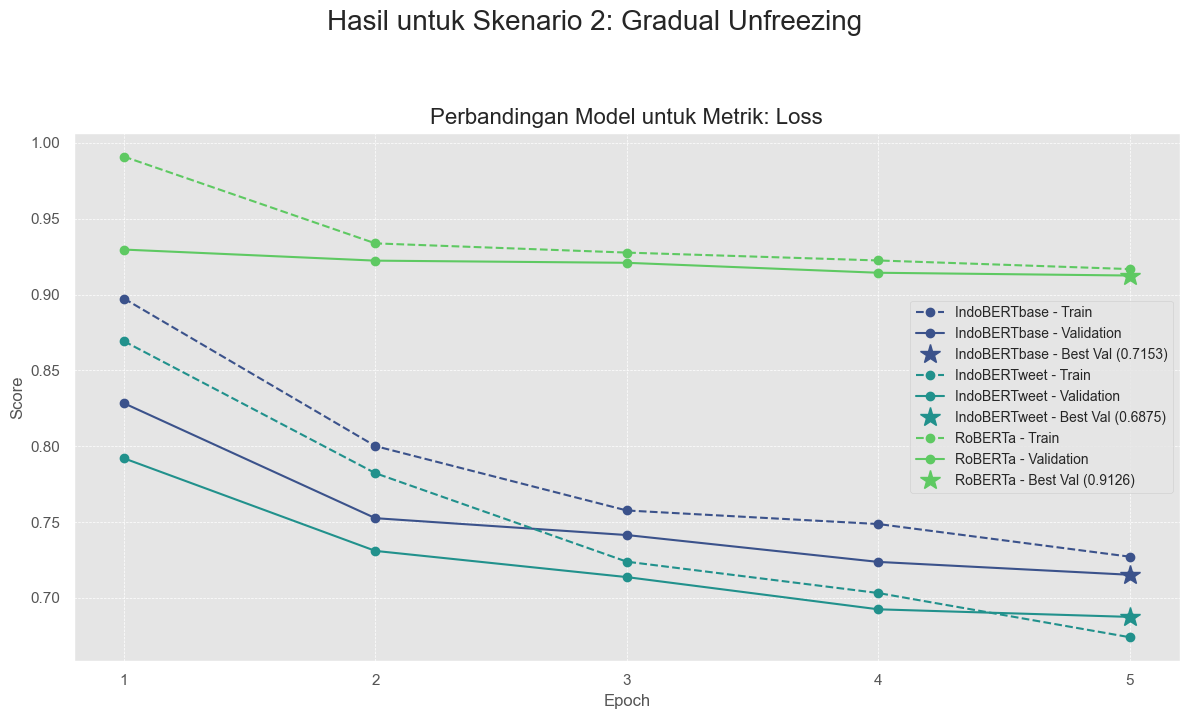

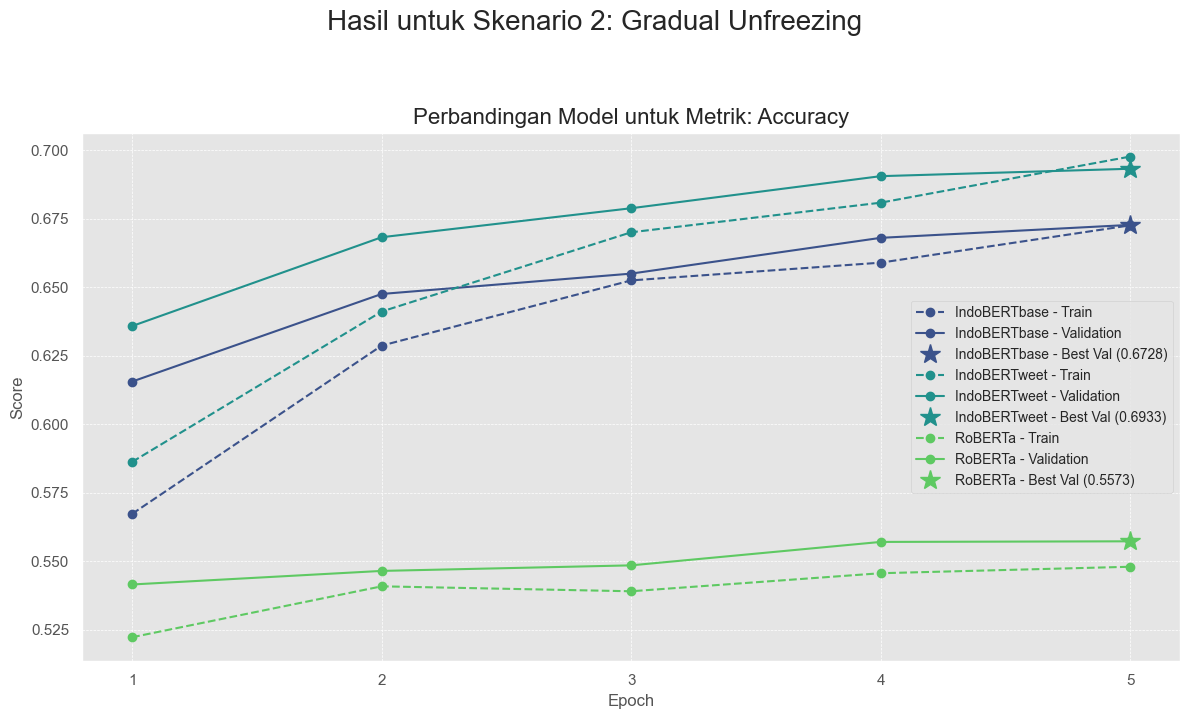

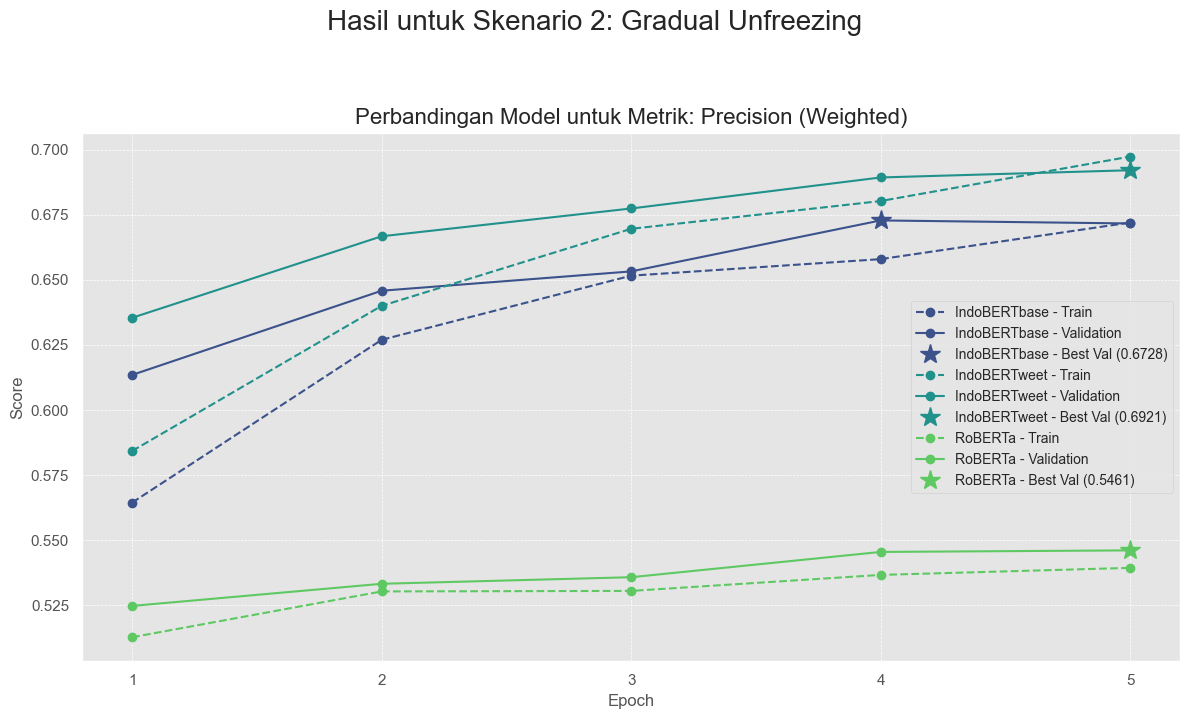

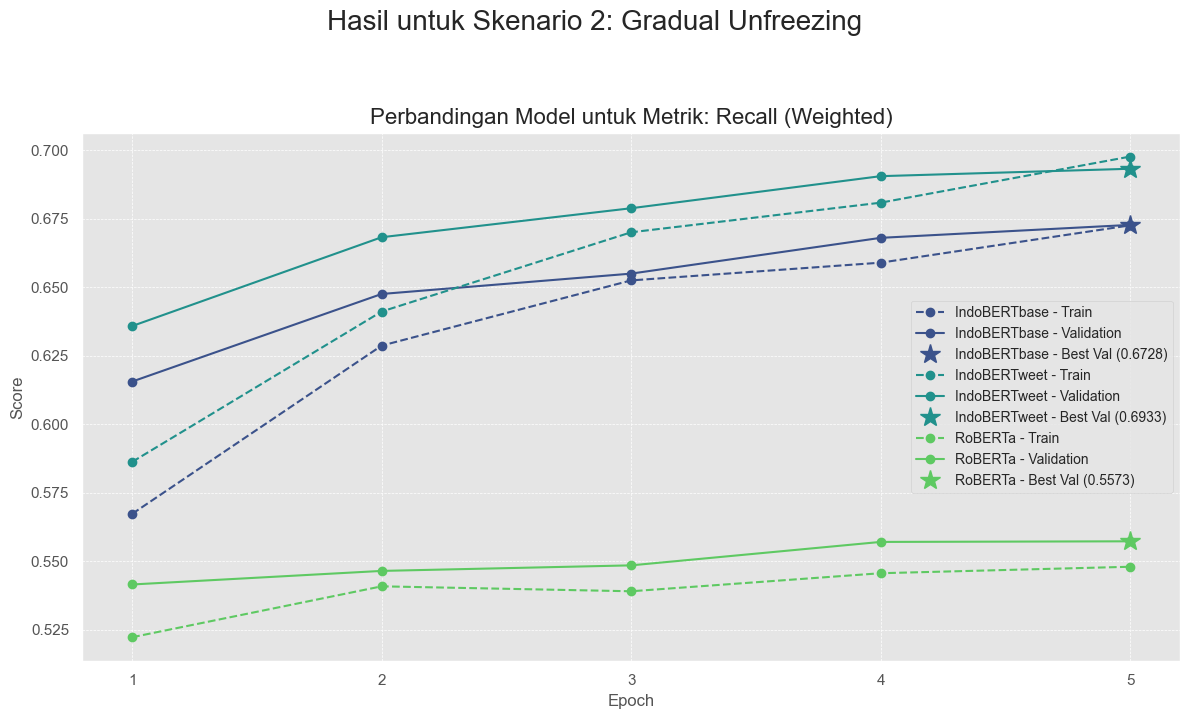

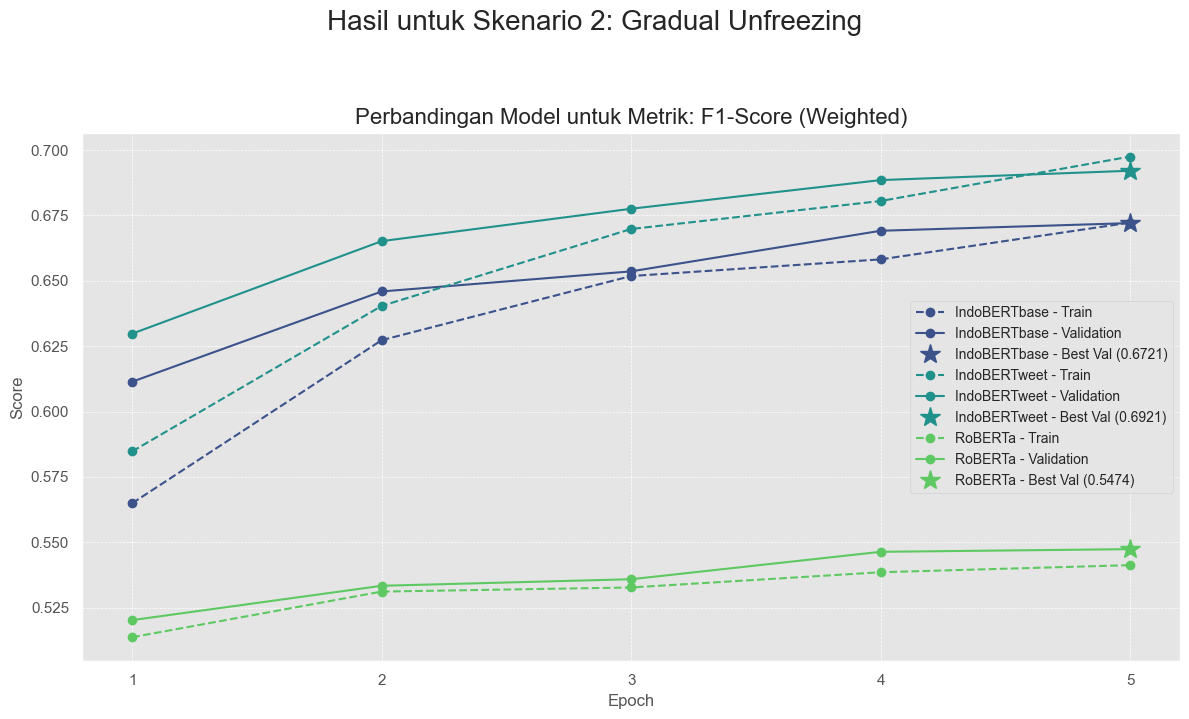

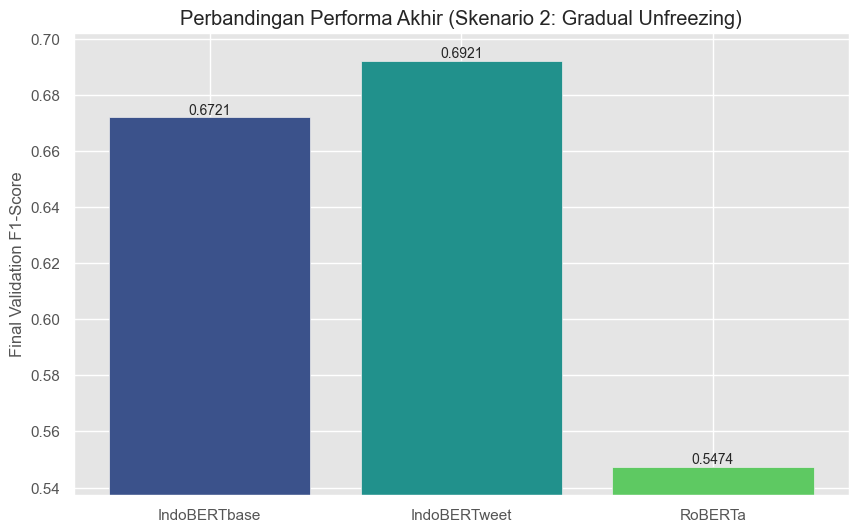

In [14]:
def plot_comparison(histories_dict, scenario_title):
    
    metrics_to_plot = ['loss', 'accuracy', 'precision', 'recall', 'f1']
    metric_titles = ['Loss', 'Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)']
    
    colors = sns.color_palette("viridis", len(histories_dict))
    model_colors = {model_name: color for model_name, color in zip(histories_dict.keys(), colors)}
    
    for i, metric in enumerate(metrics_to_plot):
        plt.figure(figsize=(12, 7))
        ax = plt.gca()
        
        for model_name, history in histories_dict.items():
            epochs_range = range(1, len(history[f'train_{metric}']) + 1)
            
            # Plot data training dengan garis putus-putus
            ax.plot(epochs_range, history[f'train_{metric}'], 'o--', color=model_colors[model_name], label=f'{model_name} - Train')
            
            # Plot data validasi dengan garis solid
            ax.plot(epochs_range, history[f'val_{metric}'], 'o-', color=model_colors[model_name], label=f'{model_name} - Validation')

            if metric == 'loss':
                best_epoch_idx = np.argmin(history[f'val_{metric}'])
            else:
                best_epoch_idx = np.argmax(history[f'val_{metric}'])
            
            best_epoch_num = best_epoch_idx + 1
            best_val_score = history[f'val_{metric}'][best_epoch_idx]
            
            ax.plot(best_epoch_num, best_val_score, '*', markersize=15, color=model_colors[model_name], 
                    label=f'{model_name} - Best Val ({best_val_score:.4f})')

        ax.set_title(f'Perbandingan Model untuk Metrik: {metric_titles[i]}', fontsize=16)
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.set_xticks(epochs_range)
        
        plt.suptitle(f'Hasil untuk {scenario_title}', fontsize=20, y=1.02)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

def plot_final_bar_chart(histories_dict, scenario_title):
    """Membuat bar plot perbandingan F1-score validasi terakhir dari semua model."""
    final_f1_scores = {model: history['val_f1'][-1] for model, history in histories_dict.items()}
    models = list(final_f1_scores.keys())
    scores = list(final_f1_scores.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, scores, color=sns.color_palette("viridis", len(models)))
    plt.ylabel('Final Validation F1-Score')
    plt.title(f'Perbandingan Performa Akhir ({scenario_title})')
    plt.ylim(min(scores) - 0.01, max(scores) + 0.01)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center') 
    
    plt.show()


def plot_comprehensive_comparison(histories_dict, scenario_title):
    """
    Membuat plot perbandingan antar model untuk semua metrik dan menyorot epoch terbaik.
    """
    
    metrics_to_plot = ['loss', 'accuracy', 'precision', 'recall', 'f1']
    metric_titles = ['Loss', 'Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)']
    
    colors = sns.color_palette("viridis", len(histories_dict))
    model_colors = {model_name: color for model_name, color in zip(histories_dict.keys(), colors)}
    
    for i, metric in enumerate(metrics_to_plot):
        plt.figure(figsize=(12, 7))
        ax = plt.gca()
        
        for model_name, history in histories_dict.items():
            epochs_range = range(1, len(history[f'train_{metric}']) + 1)
            
            # Plot data training dengan garis putus-putus
            ax.plot(epochs_range, history[f'train_{metric}'], 'o--', color=model_colors[model_name], label=f'{model_name} - Train')
            
            # Plot data validasi dengan garis solid
            ax.plot(epochs_range, history[f'val_{metric}'], 'o-', color=model_colors[model_name], label=f'{model_name} - Validation')

            if metric == 'loss':
                best_epoch_idx = np.argmin(history[f'val_{metric}'])
            else:
                best_epoch_idx = np.argmax(history[f'val_{metric}'])
            
            best_epoch_num = best_epoch_idx + 1
            best_val_score = history[f'val_{metric}'][best_epoch_idx]
            
            ax.plot(best_epoch_num, best_val_score, '*', markersize=15, color=model_colors[model_name], 
                    label=f'{model_name} - Best Val ({best_val_score:.4f})')

        ax.set_title(f'Perbandingan Model untuk Metrik: {metric_titles[i]}', fontsize=16)
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.set_xticks(epochs_range)
        
        plt.suptitle(f'Hasil untuk {scenario_title}', fontsize=20, y=1.02)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

def plot_final_bar_chart(histories_dict, scenario_title):
    """Membuat bar plot perbandingan F1-score validasi terakhir dari semua model."""
    final_f1_scores = {model: history['val_f1'][-1] for model, history in histories_dict.items()}
    models = list(final_f1_scores.keys())
    scores = list(final_f1_scores.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, scores, color=sns.color_palette("viridis", len(models)))
    plt.ylabel('Final Validation F1-Score')
    plt.title(f'Perbandingan Performa Akhir ({scenario_title})')
    plt.ylim(min(scores) - 0.01, max(scores) + 0.01)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center') 
    
    plt.show()

SCENARIO_NAME = "Skenario 2: Gradual Unfreezing" 

plot_comprehensive_comparison(all_histories, SCENARIO_NAME)
plot_final_bar_chart(all_histories, SCENARIO_NAME)